In [114]:
import numpy as np
import pandas as pd
from io import BytesIO
import requests
from PIL import Image
import sklearn.svm as skl_svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import sklearn.linear_model as skl_lm

Các bước xử lí trước khi dự đoán

In [115]:
df = pd.read_csv('pixel_dataframe2.csv')
df['pixel_matrix'] = df['pixel_matrix'].apply(lambda x: np.array([int(number) for number in x.split()]))
df['Genre'] = df['Genre'].apply(lambda x: x.split(sep=', '))

In [116]:
# đọc ảnh
def show_image(array):
    array = array.astype(np.uint8)
    array = array.reshape((60,40))

    # Tạo đối tượng Image từ mảng
    new_image = Image.fromarray(array)

    # Hiển thị ảnh
    new_image.show()

In [117]:
# lấy mảng các genre
def get_Genre(df):
    Genre = []
    for array_genre in df['Genre']:
        for i in array_genre:
            if i not in Genre:
                Genre.append(i)
    return Genre

In [118]:
Genre = get_Genre(df)

In [119]:
def get_vector_oneshot(array):# đầu vào là 1 dataframe cố định và 1 mảng để xác định oneshot vector
    Genre = ['Action','Crime','Drama','Adventure','Biography','History','Thriller','Animation','Family',
            'Documentary', 'Comedy', 'Fantasy', 'Mystery', 'Sci-Fi', 'Music', 'War', 'Romance', 'Musical',
            'Sport', 'Horror', 'News', 'Western']
    # khởi tạo vector oneshot
    vector_oneshot = np.zeros(len(Genre))
    for index, genre in enumerate(Genre):
        if genre in array:
            vector_oneshot[index] = 1
    return vector_oneshot

In [120]:
# thêm cột vector_oneshot
df['vector_oneshot'] = df['Genre'].apply(lambda x: get_vector_oneshot(x))

In [121]:
# thêm các cột genre để thể hiện có thuộc tính đó hay không
for index,i in enumerate(Genre):
    df[i] = df['vector_oneshot'].apply(lambda x: x[index])

In [122]:
# chuyển các cột sử dụng trong mô hình về list
df['pixel_matrix'] = df['pixel_matrix'].apply(lambda x: x.tolist())
df['vector_oneshot'] = df['vector_oneshot'].apply(lambda x: x.tolist())

Bảng sau khi đã thêm tất cả các cột cần thiết

In [123]:
df

,index,pixel_matrix,Genre,vector_oneshot,Action,Crime,Drama,Adventure,Biography,History,...,Mystery,Sci-Fi,Music,War,Romance,Musical,Sport,Horror,News,Western
0,0,"[62, 104, 185, 218, 221, 218, 204, 173, 131, 1...","[Action, Crime, Drama]","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,"[72, 82, 87, 99, 118, 124, 125, 111, 115, 124,...","[Action, Adventure, Drama]","[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"[235, 242, 244, 244, 244, 245, 245, 246, 247, ...","[Biography, History]","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,"[41, 42, 51, 60, 84, 94, 123, 132, 179, 220, 1...","[Action, Adventure, Drama]","[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,"[150, 134, 126, 109, 109, 117, 130, 130, 131, ...","[Action, Adventure, Drama]","[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23773,23775,"[221, 221, 221, 221, 221, 221, 221, 221, 221, ...",[Comedy],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23774,23776,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[Drama, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23775,23777,"[238, 187, 187, 186, 185, 185, 189, 192, 191, ...","[Crime, Drama, Thriller]","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23776,17118,"[59, 62, 68, 72, 66, 68, 68, 69, 66, 68, 65, 7...","[Comedy, Drama, Romance]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Tạo các tập train và test với tỉ lệ 7 : 3

In [124]:
# đầu vào 'pixel_matrix', mỗi vector có 2400 phần tử(2400 chiều)
# đầu ra: vector oneshot có 22 phần tử(22 chiều)
np.random.seed(1)
#Tạo tập train và test
trainI = np.random.choice(df.index,int(0.7*len(df)), replace= False)
trainIndex = df.index.isin(trainI)
train = df[trainIndex]
test = df[~trainIndex]

Tạo baseline cho từng thể loại bộ phim bằng cách sử dụng tần suất

MỤC TIÊU: chọn các mô hình có hiệu suất vượt baseline

In [125]:
# tần suất xuất hiện của 1 bộ phim có genre i
frequently = {}
for index, i in enumerate(Genre):
    frequently[i] = train[train[i] == 1].shape[0] / train.shape[0]

In [126]:
# sampling một bộ phim có genre i với xác suất p
def base_line(input, p):
    output = []
    for i in input:
        output.append(np.random.choice([1,0],p = [p,1-p]))
    return output

In [127]:
performent_baseline = {}
X_test = test['pixel_matrix']
for index, i in enumerate(Genre):
    
    Y_test = test[i]
    y_hat = base_line(X_test,frequently[i])

    accuracy = accuracy_score(Y_test, y_hat)
    f1 = f1_score(Y_test, y_hat)
    precision = precision_score(Y_test, y_hat)
    recall = recall_score(Y_test, y_hat)
    performent_baseline[i] = {'accuracy':accuracy, 'f1' : f1, 'precision' : precision, 'recall':recall}

print(performent_baseline)

{'Action': {'accuracy': 0.6851696103167928, 'f1': 0.20692090395480225, 'precision': 0.20619282195636876, 'recall': 0.2076541459957477}, 'Crime': {'accuracy': 0.7259601906363892, 'f1': 0.14666084679179398, 'precision': 0.1437125748502994, 'recall': 0.1497326203208556}, 'Drama': {'accuracy': 0.507569386038688, 'f1': 0.5658138672599186, 'precision': 0.5574768631271311, 'recall': 0.5744040150564618}, 'Adventure': {'accuracy': 0.8074011774600505, 'f1': 0.09724047306176084, 'precision': 0.0959792477302205, 'recall': 0.0985352862849534}, 'Biography': {'accuracy': 0.8837959069245865, 'f1': 0.0778642936596218, 'precision': 0.07760532150776053, 'recall': 0.078125}, 'History': {'accuracy': 0.9245864872441828, 'f1': 0.039285714285714285, 'precision': 0.03728813559322034, 'recall': 0.04150943396226415}, 'Thriller': {'accuracy': 0.7195121951219512, 'f1': 0.18559218559218557, 'precision': 0.19047619047619047, 'recall': 0.18095238095238095}, 'Animation': {'accuracy': 0.9219231847490889, 'f1': 0.044596

Bắt đầu quá trình dự đoán và đánh giá hiệu suất của các mô hình

Sử dụng logistic với thuật toán lbfgs

In [128]:
# dự đoán và đánh giá từng genre, thông qua mô hình Logistic
model_predict_genre = skl_lm.LogisticRegression(solver='lbfgs')
performent = {}
X_train = train['pixel_matrix'].tolist()
X_test = test['pixel_matrix'].tolist()
for index, i in enumerate(Genre):
    
    Y_train = train[i]
    Y_test = test[i]

    model_predict_genre.fit(X_train, Y_train)
    y_hat = model_predict_genre.predict(X_test)

    accuracy = accuracy_score(Y_test, y_hat)
    f1 = f1_score(Y_test, y_hat)
    precision = precision_score(Y_test, y_hat)
    recall = recall_score(Y_test, y_hat)
    performent[i] = {'accuracy':accuracy, 'f1' : f1, 'precision' : precision, 'recall':recall}
    # print("accuracy", accuracy_score(Y_test, y_hat))
print(accuracy)

c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

0.9826184468741239


In [129]:
print(performent)

{'Action': {'accuracy': 0.7678721614802355, 'f1': 0.1752988047808765, 'precision': 0.2948073701842546, 'recall': 0.12473423104181432}, 'Crime': {'accuracy': 0.815811606391926, 'f1': 0.12283044058744993, 'precision': 0.24468085106382978, 'recall': 0.08199643493761141}, 'Drama': {'accuracy': 0.5332211942809083, 'f1': 0.6226201269265639, 'precision': 0.5676792725769787, 'recall': 0.6893350062735257}, 'Adventure': {'accuracy': 0.867255396691898, 'f1': 0.042467138523761376, 'precision': 0.08823529411764706, 'recall': 0.02796271637816245}, 'Biography': {'accuracy': 0.9151948416035884, 'f1': 0.03815580286168521, 'precision': 0.06629834254143646, 'recall': 0.026785714285714284}, 'History': {'accuracy': 0.9437902999719653, 'f1': 0.024330900243309, 'precision': 0.03424657534246575, 'recall': 0.018867924528301886}, 'Thriller': {'accuracy': 0.7957667507709559, 'f1': 0.10558624923265807, 'precision': 0.23306233062330622, 'recall': 0.06825396825396825}, 'Animation': {'accuracy': 0.9353798710400897, 

In [130]:
data_frame = pd.DataFrame(performent)

In [131]:
data_frame

,Action,Crime,Drama,Adventure,Biography,History,Thriller,Animation,Family,Documentary,...,Mystery,Sci-Fi,Music,War,Romance,Musical,Sport,Horror,News,Western
accuracy,0.767872,0.815812,0.533221,0.867255,0.915195,0.943790,0.795767,0.935380,0.941267,0.917998,...,0.893468,0.933838,0.948696,0.960892,0.785254,0.971825,0.958649,0.852117,0.994253,0.982618
f1,0.175299,0.122830,0.622620,0.042467,0.038156,0.024331,0.105586,0.033543,0.004751,0.048780,...,0.059406,0.024793,0.046875,0.021053,0.082635,0.019512,0.013378,0.080209,0.000000,0.015873
precision,0.294807,0.244681,0.567679,0.088235,0.066298,0.034247,0.233062,0.045977,0.006135,0.074627,...,0.144578,0.041958,0.051429,0.017544,0.140816,0.014388,0.013333,0.206278,0.000000,0.009901
recall,0.124734,0.081996,0.689335,0.027963,0.026786,0.018868,0.068254,0.026403,0.003876,0.036232,...,0.037383,0.017595,0.043062,0.026316,0.058475,0.030303,0.013423,0.049784,0.000000,0.040000


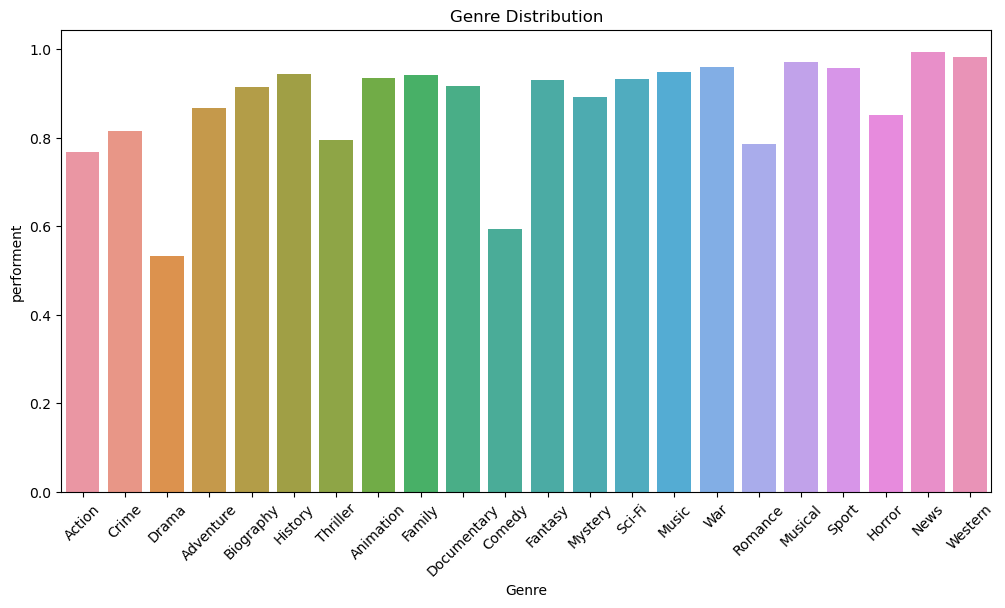

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Vẽ đồ thị bằng seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x = data_frame.columns.values, y = data_frame.iloc[0].values)
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('performent')
plt.title('Genre Distribution')

# Hiển thị đồ thị
plt.show()

Cải thiện mô hình dự đoán

In [133]:
data_frame.iloc[0]

Action         0.767872
Crime          0.815812
Drama          0.533221
Adventure      0.867255
Biography      0.915195
History        0.943790
Thriller       0.795767
Animation      0.935380
Family         0.941267
Documentary    0.917998
Comedy         0.595178
Fantasy        0.931876
Mystery        0.893468
Sci-Fi         0.933838
Music          0.948696
War            0.960892
Romance        0.785254
Musical        0.971825
Sport          0.958649
Horror         0.852117
News           0.994253
Western        0.982618
Name: accuracy, dtype: float64

Dự đoán nhiều Genre cùng 1 lúc

<!--  -->

In [134]:
# chọn model
def set_model(genre):
    # các điều kiện
    model = skl_lm.LogisticRegression(solver='lbfgs')
    return model

In [135]:
# mô hình nhà máy, dự đoán từng genre một
model = {}
for index, i in enumerate(Genre):
    model[i] = set_model(i)

X_train = train['pixel_matrix'].tolist()

for index, i in enumerate(Genre):
    
    model_i = model[i]

    Y_train = train[i]

    model_i.fit(X_train, Y_train)

c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\PC\miniconda3\envs\manhtms1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [136]:
X_test = test['pixel_matrix'].to_list()
Y_test = test['vector_oneshot'].to_list()

# predict, đánh giá hiệu suất:
y_hat = []

for genre in Genre:
    yi_hat = model[genre].predict(X_test)
    
    y_hat.append(yi_hat)
y_hat = np.transpose(y_hat)
# print(accuracy_score(y_hat, Y_test))

In [137]:
def my_accuracy(y_hat, Y_test):
    count = 0
    for index,i in enumerate(y_hat):
        if y_hat[index] == Y_test[index]:
            count += 1
    return count / len(y_hat)

In [138]:
print(my_accuracy(y_hat.tolist(), Y_test))

0.0496215306980656


In [140]:
# cải thiện hiệu suất: accuracy thấp do thiếu thông tin, khai thác thêm thông tin
from sklearn.metrics import confusion_matrix

# Giả sử y_true là nhãn thực tế và y_pred là nhãn dự đoán
y_true = [1, 0, 0, 1, 1, 1]
y_pred = [0, 0, 1, 1, 1, 0]

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

[[1 1]
 [2 2]]
